In [578]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv
import lib.plot.table as plttbl

import os
import math
import numpy as np

In [598]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)
importlib.reload(plttbl)

<module 'lib.plot.table' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/table.py'>

### Load data

In [17]:
path,resultsdir,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
#path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"
path

'M06_th45/'

In [18]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

### transform frame

In [5]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields
dflow = ft.transform_flow(dflow,vshock)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


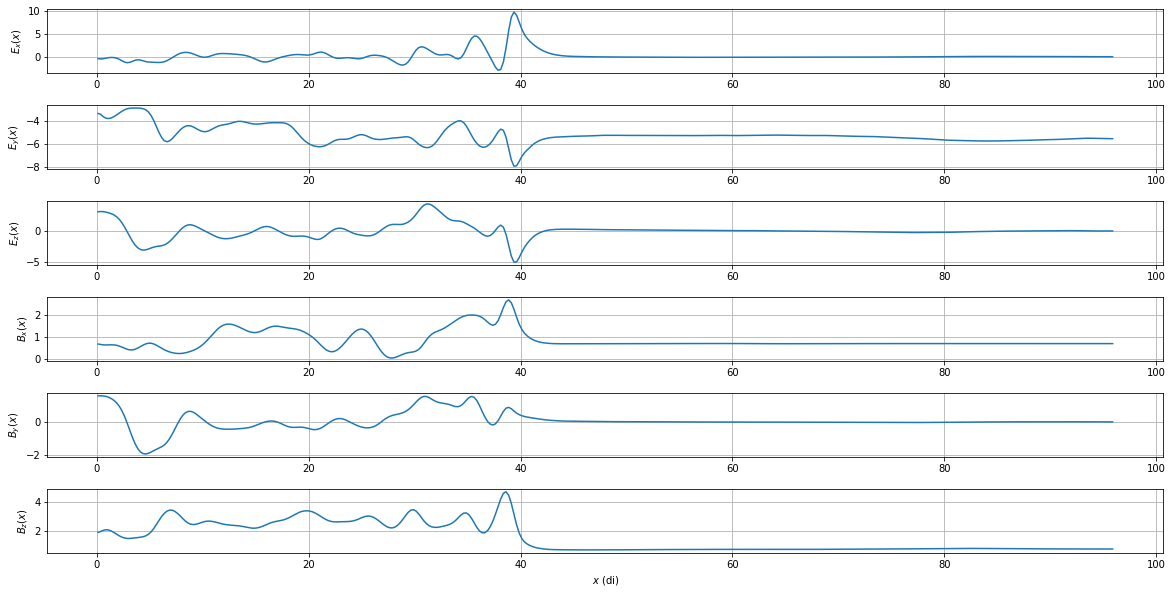

In [6]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

In [7]:
dfields['bz'][1,2,4]

2.046367

### select x region to analyze

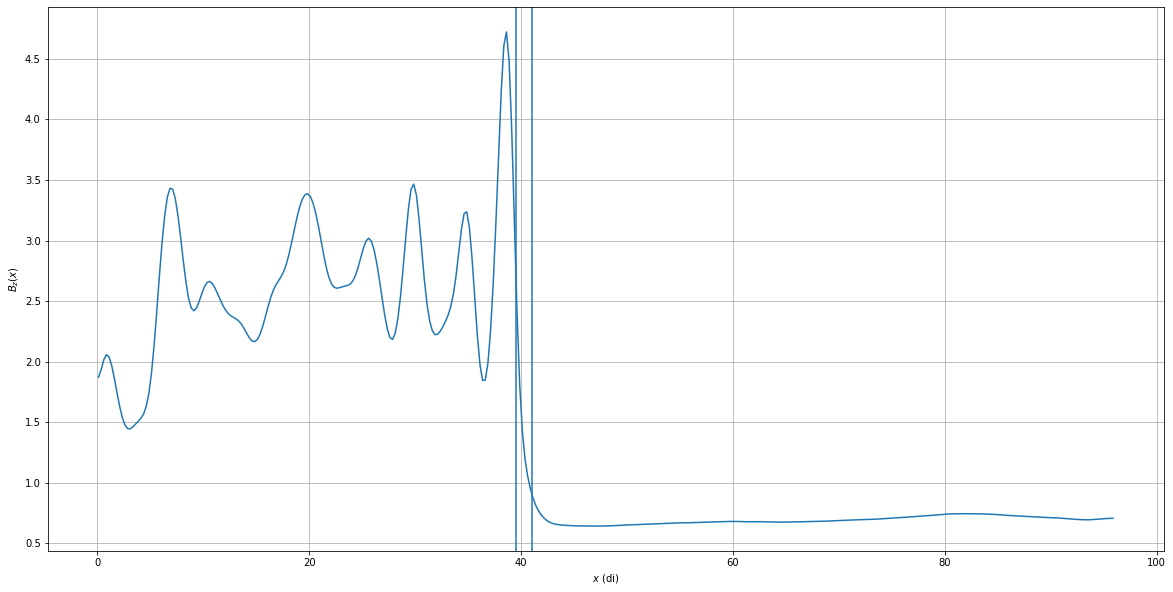

In [8]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startvalramp = 39.5#lower bound for metadata = 1 (di)
endvalramp = 41. #upper bound for metadata = 1 (di)

midrampx = (startvalramp+endvalramp)/2.
midrampidx = ao.find_nearest(dfields['bz_xx'],midrampx)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startvalramp, axvx2 = endvalramp)

### get fluctuations

In [9]:
dflow.keys()

dict_keys(['ux', 'ux_xx', 'ux_yy', 'ux_zz', 'uy', 'uy_xx', 'uy_yy', 'uy_zz', 'uz', 'uz_xx', 'uz_yy', 'uz_zz', 'id', 'Vframe_relative_to_sim'])

In [10]:
dfields['bz'][1,2,4]

2.046367

In [11]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)
dflowfluc = anl.remove_average_flow_over_yz(dflow)

In [12]:
dfields['bz'][1,2,4]

2.046367

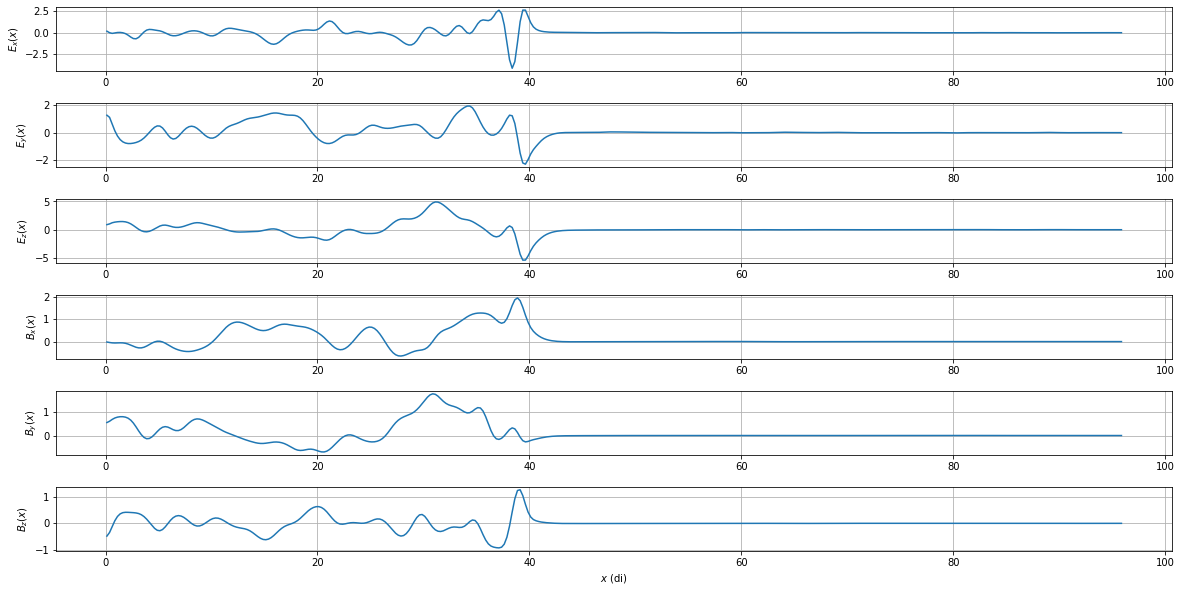

In [13]:
plt1d.plot_all_fields(dfieldsfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### get relevant subset

In [14]:
dfields['bz'][1,2,4]

2.046367

In [15]:
dfieldssubset = ao.get_field_subset(dfields,startvalramp,endvalramp,0.,12.,0.,12.)
dflowsubsset = ao.get_flow_subset(dflow,startvalramp,endvalramp,0.,12.,0.,12.)

dfieldflucsubset = ao.get_field_subset(dfieldsfluc,startvalramp,endvalramp,0.,12.,0.,12.)
dflowflucsubsset = ao.get_flow_subset(dflowfluc,startvalramp,endvalramp,0.,12.,0.,12.)

In [16]:
dfields['bz'][1,2,4]

2.046367

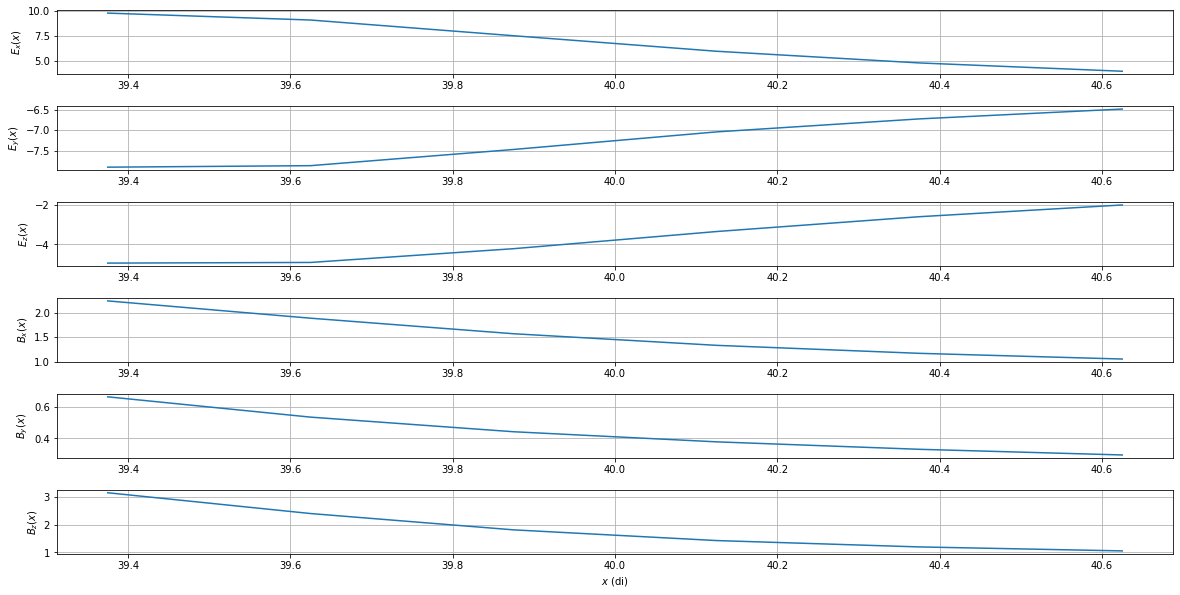

In [17]:
plt1d.plot_all_fields(dfieldssubset, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### look at average yz averaged fields

In [18]:
dfields['bz'][1,2,4]

2.046367

In [19]:
dfieldsavg = anl.get_average_fields_over_yz(dfields)

In [20]:
dfields['bz'][1,2,4]

1.7795179

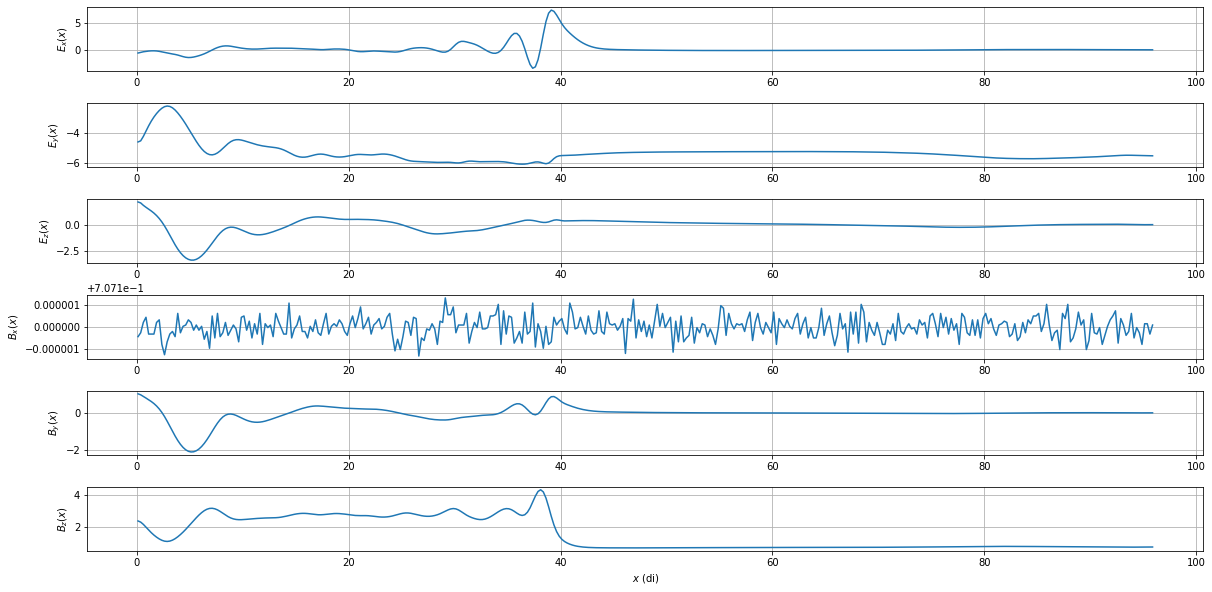

In [21]:
plt1d.plot_all_fields(dfieldsavg, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Take FFT

In [22]:
dfields['bz'][1,2,4]

1.7795179

In [23]:
fftbx = np.fft.fftn(dfieldflucsubset['bx'])
fftby = np.fft.fftn(dfieldflucsubset['by'])
fftbz = np.fft.fftn(dfieldflucsubset['bz'])
fftex = np.fft.fftn(dfieldflucsubset['ex'])
fftey = np.fft.fftn(dfieldflucsubset['ey'])
fftez = np.fft.fftn(dfieldflucsubset['ez'])
fftux = np.fft.fftn(dflowflucsubsset['ux'])
fftuy = np.fft.fftn(dflowflucsubsset['uy'])
fftuz = np.fft.fftn(dflowflucsubsset['uz'])

In [24]:
dfields['bz'][1,2,4]

1.7795179

### Test Wavelet Transform over xx

In [25]:
#first calculate Bi(x,ky,kz) (or Ei(x,ky,kz))
fieldkey = 'bz'

In [26]:
dfields['bz'][1,2,4]

1.7795179

In [27]:
#spacing in grids, needed to get wavenumber from fft
daxis0 = dfieldsfluc[fieldkey+'_zz'][1]-dfieldsfluc[fieldkey+'_zz'][0]
daxis1 = dfieldsfluc[fieldkey+'_yy'][1]-dfieldsfluc[fieldkey+'_yy'][0]

fieldfftsweepoverx = []
for xxindex in range(0,len(dfieldsfluc[fieldkey][0][0])):
    fieldslice = np.asarray(dfieldsfluc[fieldkey])[:,:,xxindex]
    kz, ky, fieldslicefft = anl.take_fft2(fieldslice,daxis0,daxis1)
    fieldfftsweepoverx.append(fieldslicefft)
fieldfftsweepoverx = np.asarray(fieldfftsweepoverx)

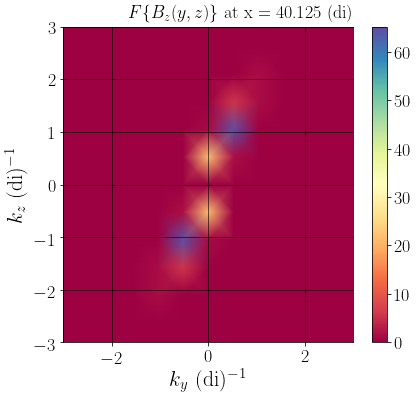

In [28]:
pltfr.plot_fft_norm(dfieldsfluc, fieldkey,'yz', takeaxisaverage=False, xxindex=midrampidx, plotlog=False,xaxislim=3,yaxislim=3) 

(Pick one of the following options to find a kyidx and kzidx that we are going to be analyzing)

##### option 1

In [29]:
#pick ky kz by using max
kyidx, kzidx = np.unravel_index(np.argmax(fieldfftsweepoverx[midrampidx], axis=None), fieldfftsweepoverx[midrampidx].shape)

##### option 2

In [30]:
# #hand pick ky, kz using above plot
# kyidx = ao.find_nearest(ky,.5)
# kzidx = ao.find_nearest(kz,1.)

In [31]:
#take slice at given ky kz
xkykzdata = fieldfftsweepoverx[:,kzidx,kyidx] #TODO: Double check if ky and kz should be flipped
ky0 = ky[kyidx]
kz0 = kz[kzidx]

In [32]:
dfields['bz'][1,2,4]

1.7795179

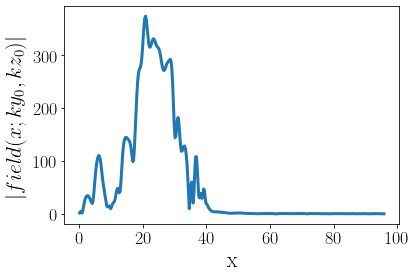

In [33]:
#plot norm
import matplotlib.pyplot as plt
temp = np.absolute(xkykzdata)
plt.figure()
plt.ylabel('$|field(x;ky_0,kz_0)|$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

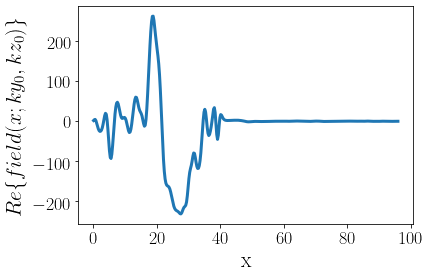

In [34]:
#plot real component
import matplotlib.pyplot as plt
temp = np.real(xkykzdata)
plt.figure()
plt.ylabel('$Re\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

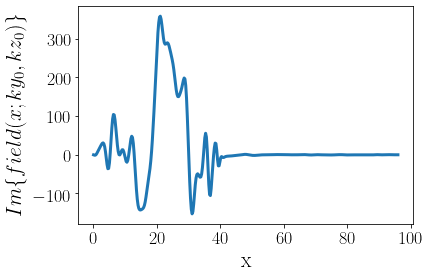

In [35]:
#plot imag component
import matplotlib.pyplot as plt
temp = np.imag(xkykzdata)
plt.figure()
plt.ylabel('$Im\{field(x;ky_0,kz_0)\}$')
plt.xlabel('x')
plt.plot(dfieldsfluc[fieldkey+'_xx'],temp)
plt.show()

In [36]:
dfields['bz'][1,2,4]

1.7795179

### Test Wavelet Transform over xx

In [37]:
kx, wlt = anl.wlt(dfieldsfluc[fieldkey+'_xx'],xkykzdata)

In [38]:
dfields['bz'][1,2,4]

1.7795179

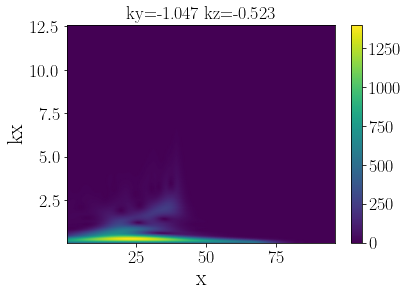

In [39]:
plt.figure()
plt.pcolormesh(dfieldsfluc[fieldkey+'_xx'],kx,np.abs(wlt),cmap='viridis', shading='gouraud')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('kx')
plt.title('ky='+str(ky0)[0:6]+' kz='+str(kz0)[0:6])
flnm='ky='+str(ky0)[0:6]+'kz='+str(kz0)[0:6]+'wlt'
plt.savefig(flnm+'.png',format='png')
plt.show()

### Test routine that checks all predicted wave modes and sees if they are alfvenic

In [727]:
#pick some test position in the simulation
xx = 41.
yy = 5.
zz = 0.

#look at potential wavemodes
fieldkey = 'bz'
kxlist, kylist, kzlist, kxplotlist, wltplotlist, prcntmaxlist = anl.find_potential_wavemodes(dfields,fieldkey,xx,cutoffconst=.1)

In [728]:
xxidx = ao.find_nearest(dfields['bz_xx'],xx)

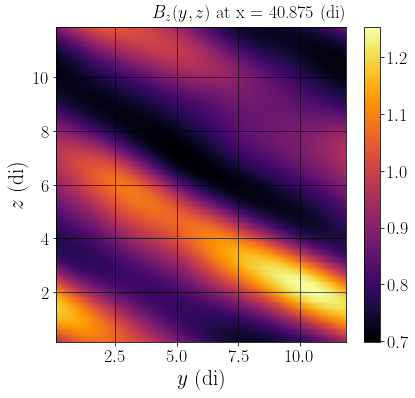

In [729]:
plt2d.make_field_pmesh(dfields,fieldkey,'yz',takeaxisaverage=False, xxindex=xxidx)

In [730]:
#(for alfvenic wave, we would expect 1,0,0)

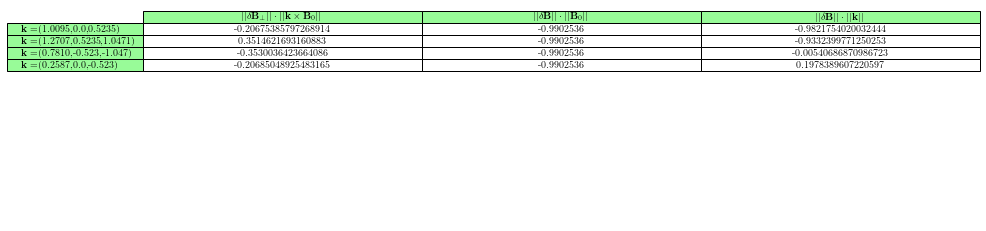

In [731]:
#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

#test given k's
results = anl.alfven_wave_check(dfields,klist,xx,yy,zz)

#build and make table
results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
collbls = [r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$',
           r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$',
           r'$|| \delta \mathbf{B} || \cdot || \mathbf{k} ||$']
rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
plttbl.make_table(rowlbls,collbls,results_table,ttl='',flnm='')

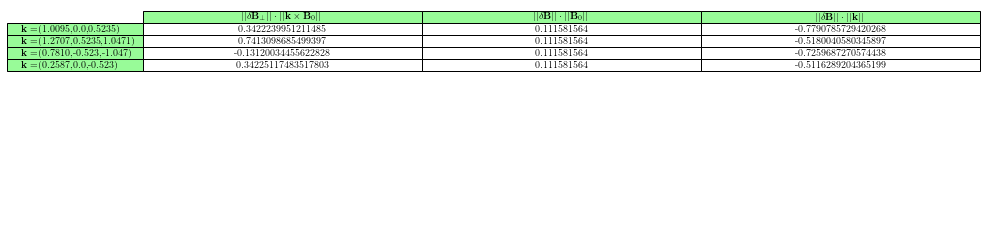

In [732]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

#test given k's
results = anl.alfven_wave_check(dfieldsfluc,klist,xx,yy,zz)

#build and make table
results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
collbls = [r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$',
           r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$',
           r'$|| \delta \mathbf{B} || \cdot || \mathbf{k} ||$']
rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
plttbl.make_table(rowlbls,collbls,results_table,ttl='',flnm='')

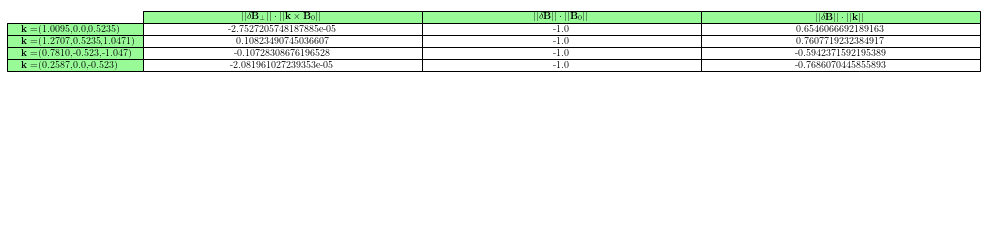

In [733]:
dfieldsfluc = anl.remove_average_fields_over_yz(dfields)

dfieldsavg = anl.get_average_fields_over_yz(dfieldsfluc)

#build list of k's to test
klist = [[kxlist[i],kylist[i],kzlist[i]] for i in range(0,len(kxlist))]

#test given k's
results = anl.alfven_wave_check(dfieldsavg,klist,xx,yy,zz)

#build and make table
results_table = [[results[i][j][1] for j in range(0,len(results[i]))] for i in range(0,len(results))]
collbls = [r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$',
           r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$',
           r'$|| \delta \mathbf{B} || \cdot || \mathbf{k} ||$']
rowlbls = ['$\mathbf{k} = $('+str(klist[i][0])[0:6]+','+str(klist[i][1])[0:6]+','+str(klist[i][2])[0:6]+')' for i in range(0,len(klist))]
plttbl.make_table(rowlbls,collbls,results_table,ttl='',flnm='')

### Look at spatial structure of delB dot B0 and other plotted quantities

In [740]:
#get external field
B0 = anl.get_B0(dfieldsfluc)

#get delta fields (different from removing yz average)
ddeltaf = anl.get_delta_fields(dfieldsfluc,B0)

#get delta perp fields
dperpf = get_delta_perp_fields(dfieldsfluc,B0)

xxidx = ao.find_nearest(dfields['bz_xx'],xx)

quant1 = []
quant2 = []
quant3 = []
kidx = 0
for yyidx in range(0,len(dfields['bz_yy'])):
    row1 = []
    row2 = []
    row3 = []
    for zzidx in range(0,len(dfields['bz_zz'])):
        k = klist[kidx]
        kcrossB0 = np.cross(k,B0)
        delB = [ddeltaf['bx'][zzidx,yyidx,xxidx],ddeltaf['by'][zzidx,yyidx,xxidx],ddeltaf['bz'][zzidx,yyidx,xxidx]]
        delBperp = [dperpf['bx'][zzidx,yyidx,xxidx],dperpf['by'][zzidx,yyidx,xxidx],dperpf['bz'][zzidx,yyidx,xxidx]]

        row1.append(anl.is_parallel(delBperp,kcrossB0,tol=0.1)[1])
        row2.append(anl.is_perp(delB,B0,tol=0.1)[1])
        row3.append(anl.is_perp(delB,k,tol=.1)[1])
    quant1.append(row1)
    quant2.append(row2)
    quant3.append(row3)
quant1 = np.asarray(quant1)
quant2 = np.asarray(quant2)
quant3 = np.asarray(quant3)

In [741]:
k

[1.0095749968768455, 0.0, 0.5235987755982988]

In [742]:
#make 2d arrays for more explicit plotting
xplot = np.zeros((len(dfields['bz_zz']),len(dfields['bz_yy'])))
yplot = np.zeros((len(dfields['bz_zz']),len(dfields['bz_yy'])))
for i in range(0,len(dfields['bz_zz'])):
    for j in range(0,len(dfields['bz_yy'])):
        xplot[i][j] = dfields['bz_yy'][j]

for i in range(0,len(dfields['bz_zz'])):
    for j in range(0,len(dfields['bz_yy'])):
        yplot[i][j] = dfields['bz_zz'][i]

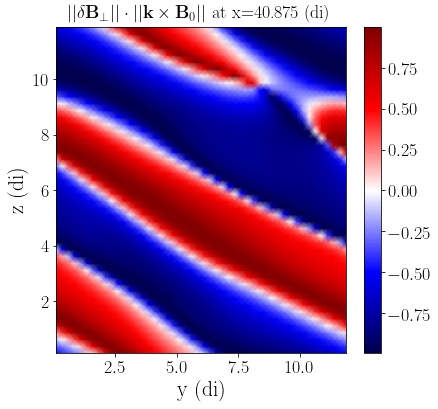

In [743]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5,6))
plt.style.use("postgkyl.mplstyle")
plt.pcolormesh(xplot, yplot, quant1.T, cmap="seismic", shading="gouraud")
plt.colorbar()
plt.xlabel('y (di)')
plt.ylabel('z (di)')
plt.title(r'$|| \delta \mathbf{B}_\perp || \cdot || \mathbf{k} \times \mathbf{B}_0 ||$ at x='+str(dfields['bz_xx'][xxidx])+' (di)')
plt.show()

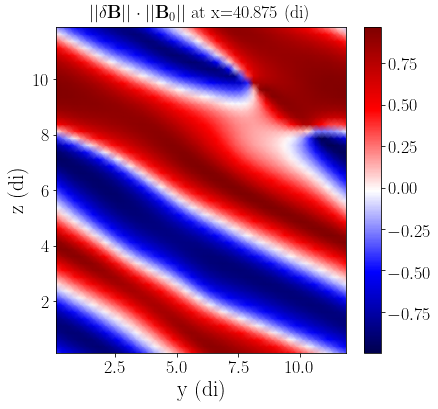

In [744]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5,6))
plt.style.use("postgkyl.mplstyle")
plt.pcolormesh(xplot, yplot, quant2.T, cmap="seismic", shading="gouraud")
plt.colorbar()
plt.xlabel('y (di)')
plt.ylabel('z (di)')
plt.title(r'$|| \delta \mathbf{B} || \cdot || \mathbf{B}_0 ||$ at x='+str(dfields['bz_xx'][xxidx])+' (di)')
plt.show()

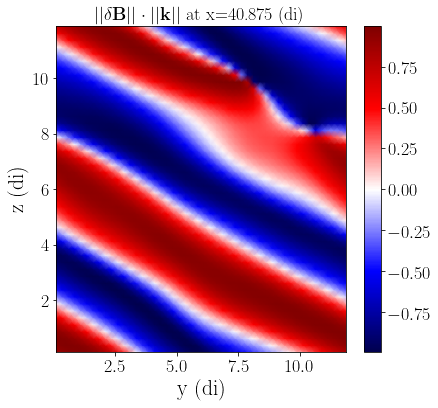

In [745]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6.5,6))
plt.style.use("postgkyl.mplstyle")
plt.pcolormesh(xplot, yplot, quant3.T, cmap="seismic", shading="gouraud")
plt.colorbar()
plt.xlabel('y (di)')
plt.ylabel('z (di)')
plt.title( r'$|| \delta \mathbf{B} || \cdot || \mathbf{k} ||$ at x='+str(dfields['bz_xx'][xxidx])+' (di)')
plt.show()

### See what kx needs to be given some ky, kz

In [593]:
#pick some test position in the simulation
xx = 40.
yy = 5.
zz = 0.

#look at potential wavemodes
fieldkey = 'bz'
kxlist, kylist, kzlist, kxplotlist, wltplotlist, prcntmaxlist = anl.find_potential_wavemodes(dfields,fieldkey,xx,cutoffconst=.1)

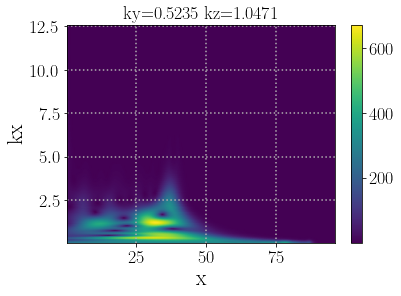

In [594]:
#TODO: generate plots related to the true part here
i = 1
pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', xlim = None, ylim = None)

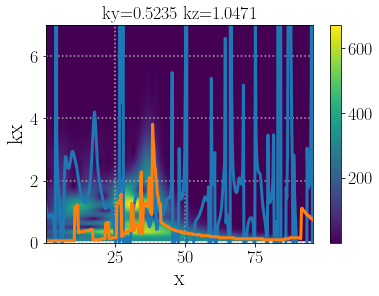

In [595]:
#plot what kx would need to be given ky kz along some 
k = [kxlist[i],kylist[i],kzlist[i]]
xxvals = []
kxvals = []
for xidx in range(0,len(dfields['bz_xx'])):
    xxidx = xidx
    delBperp = [dperpf['bx'][zzidx,yyidx,xxidx],dperpf['by'][zzidx,yyidx,xxidx],dperpf['bz'][zzidx,yyidx,xxidx]]
    kxvals.append(predict_kx(k[1],k[2],B0,delBperp))
    xxvals.append(dfields['bz_xx'][xidx])
pltfr.plot_wlt(dfields['bz_xx'], kxplotlist[i], wltplotlist[i], ky0 = kylist[i], kz0 = kzlist[i], flnm = '', plotstrongestkx = True, ylim = [0,7], xxline = xxvals, yyline = kxvals)

### Looks like we need to find local maximum instead of absolute maxima and see if any of those are alfvenic

In [499]:
wlttemp = wltplotlist[0]
xx = dfields['bz_xx']
xidx = ao.find_nearest(xx,90)
wltslice = np.abs(wlttemp[:,xidx])


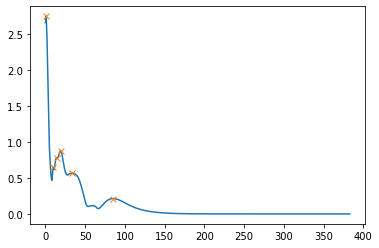

[1, 10, 14, 19, 33, 85]

In [500]:
ao.find_local_maxima(wltslice,threshold = .05,pltdebug = True)